In [185]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
from scipy.stats import norm
import seaborn as sns
from scipy import stats

In [570]:
data = pd.read_csv('data1.csv')
data.head()

,platform_open_id,goods_num,price,is_member,discount_fee,outer_id,take_at,status,payment,member_id,order_payment,total_fee,goods_id
0,101ZX1xyfG/omvnxQPYI8YPFhoi2hfl26RoAPgzb9VqwG0=,1,3650.0,0,300.0,302945-01,2020-01-01 01:35:43,6,3350.0,0,3350.0,3350.0,520399672992
1,爱012Pr5yntLUcTKU0MtsjPGOs2DEMds1FAQI7fgfrP3PMg=,1,2690.0,0,600.0,227605-01,2020-01-01 08:55:17,6,2090.0,0,2090.0,2090.0,548452717637
2,朱01i4Rmip4x6V5VS/UZPBzc+Nnn6lnZ7cacExIx+8aylCY=,1,3990.0,1,400.0,226403-01,2020-01-01 09:48:35,6,3590.0,616297,3590.0,3590.0,564779472639
3,001bRbDk61o6cYW1XuaH8XgLgKHM0CMIQafAKaTQc17qGM=,1,3290.0,0,0.0,NaN,2020-01-01 09:56:04,6,3290.0,0,3290.0,3290.0,609664493135
4,t014Au7WHWPPI0OeT5DX13SQ5q8qGekDqre2uZnHtcQpY8=,1,3590.0,1,500.0,282846-01,2020-01-01 10:36:50,6,3090.0,220404,3090.0,3090.0,589083659427


In [588]:
# 提取时间戳“take_at”有用信息 这里的'int_date'用于根据购买时间进行排序，因为上面可以看出时间顺序有错误
date1 = data['take_at'].str.split(' ').str[0]
date2 = data['take_at'].str.split(' ').str[1]
data['year-month-day']=date1
time_1 = date1.str.split('-').str[0]+date1.str.split('-').str[1]
print(time_1)
data['int_date'] = time_1
# 得到最后的要统计的数据
# 得到最后的要统计的数据（取需要的列，将int_date转换成int类型，便于根据时间排序，也可以作为特征）
data_last = data[['year-month-day','status','int_date','goods_id','price','discount_fee','payment']]

# 关闭 SettingWithCopy警告，解决可以通过（.copy()）
pd.set_option('mode.chained_assignment', None)
data_last["int_date"] = pd.to_numeric(data_last["int_date"])
data_last.sort_values("int_date",inplace=True)

# 只取状态6，也就是交易成功，不考虑退款情况的
data_last=data_last[data_last['status']==6]
# data_last = data_last.drop(data_last[(data_last['payment']<10)].index)
data_last = data_last[['year-month-day','int_date','goods_id','price','discount_fee','payment']]
data_last.head(-5)

0          202001
1          202001
2          202001
3          202001
4          202001
            ...  
2076751    202106
2076752    202106
2076753    202106
2076754    202106
2076755    202106
Name: take_at, Length: 2076756, dtype: object


,year-month-day,int_date,goods_id,price,discount_fee,payment
0,2020-01-01,202001,520399672992,3650.00,300.0,3350.00
1208762,2020-01-09,202001,548452717637,2690.00,600.0,2090.00
1208758,2020-01-09,202001,564779472639,3990.00,400.0,3590.00
1208757,2020-01-09,202001,558595903364,1950.00,400.0,1550.00
1208756,2020-01-09,202001,609664493135,3290.00,0.0,3290.00
...,...,...,...,...,...,...
521961,2021-06-03,202106,593426803862,0.01,0.0,0.01
521963,2021-06-03,202106,593426803862,0.01,0.0,0.01
521964,2021-06-03,202106,593426803862,0.01,0.0,0.01
521955,2021-06-03,202106,593426803862,0.01,0.0,0.01


In [771]:
data_day = data_last.groupby('year-month-day')
# 每一天的GMV数据(status=6)
day_ = list(data_day)
gmv_day= []
for i in range(len(list(data_day))):
    gmv_1=day_[i][1]['payment'].sum()
    gmv_day.append(gmv_1)
gmv_day

[8117806.0,
 2465348.0,
 2298608.0,
 2071824.0,
 1269618.0,
 25925036.0,
 8077788.0,
 7446776.0,
 8343364.0,
 7927048.0,
 3116266.0,
 3223466.0,
 3253080.0,
 2525816.0,
 13044796.0,
 5895848.0,
 4473678.0,
 3856678.0,
 3862996.0,
 3048520.0,
 2756670.0,
 2351418.0,
 2681438.0,
 2677160.0,
 3060880.0,
 3401030.0,
 4584176.0,
 4317098.0,
 5169278.0,
 6052270.0,
 2134600.0,
 2531606.0,
 2254110.0,
 1930700.0,
 1951782.0,
 1674616.0,
 2351170.0,
 1302224.0,
 11797250.0,
 6550372.0,
 7453448.0,
 5799996.0,
 7708266.0,
 7175370.0,
 9701312.0,
 2738680.0,
 3050736.0,
 6949658.0,
 10934650.0,
 6796726.0,
 6812140.0,
 6717760.0,
 6012430.0,
 3049128.0,
 2939154.0,
 2201574.02,
 1776858.0,
 1644456.01,
 9282638.01,
 5007416.199999999,
 5449684.0,
 1778064.0,
 1389410.0,
 763664.0,
 26300587.049999997,
 12358904.04,
 10764140.02,
 14764669.2,
 4618097.07,
 1319156.13,
 1263800.1400000001,
 1196945.24,
 6528064.68,
 3746306.58,
 4819894.8100000005,
 1845006.2399999998,
 1782552.1600000001,
 187499

In [752]:
up_day=[]
for i in range(len(gmv_day)):
    if i>=len(gmv_day)-1:
        continue
    else:
        up_day.append(gmv_day[i+1]-gmv_day[i])
print(len(up_day))

holidays_ = pd.DataFrame({'time':[],'up':[]})
start_date = "20200102"
date_list2 = pd.date_range(start=start_date, periods=546).strftime("%Y-%m-%d").tolist()
holidays_['time'] = date_list2
holidays_['up'] = up_day
holidays1_ = holidays_[(holidays_['up'] >=10000000)]
holidays2_ = holidays_[(holidays_['up'] >=30000000)]
print(f'--------普通购物日：{len(holidays1_)}')
print(f'--------超级购物日：{len(holidays2_)}')

playoffs = pd.DataFrame({ 'holiday': 'playoff', 'ds': pd.to_datetime(holidays1_['time']), 'lower_window': 0, 'upper_window': 1,})
superbowls = pd.DataFrame({ 'holiday': 'superbowl', 'ds': pd.to_datetime(holidays2_['time']),'lower_window': 0, 'upper_window': 1,})
holidays_last = pd.concat((playoffs, superbowls))
print(holidays_last)

546
--------普通购物日：28
--------超级购物日：10
       holiday         ds  lower_window  upper_window
4      playoff 2020-01-06             0             1
13     playoff 2020-01-15             0             1
37     playoff 2020-02-08             0             1
63     playoff 2020-03-05             0             1
144    playoff 2020-05-25             0             1
151    playoff 2020-06-01             0             1
160    playoff 2020-06-10             0             1
166    playoff 2020-06-16             0             1
168    playoff 2020-06-18             0             1
251    playoff 2020-09-09             0             1
293    playoff 2020-10-21             0             1
303    playoff 2020-10-31             0             1
304    playoff 2020-11-01             0             1
313    playoff 2020-11-10             0             1
314    playoff 2020-11-11             0             1
330    playoff 2020-11-27             0             1
343    playoff 2020-12-10             0     

In [772]:
data_to_use = pd.DataFrame({'ds':[],'y':[]})
data_to_use

,ds,y


In [783]:
# 生成时间列表
start_date = "20200101"
date_list = pd.date_range(start=start_date, periods=547).strftime("%Y-%m-%d").tolist()
data_to_use['ds'] = date_list
data_to_use['y'] = np.log(gmv_day)
data_to_use

,ds,y
0,2020-01-01,15.909570
1,2020-01-02,14.717844
2,2020-01-03,14.647814
3,2020-01-04,14.543940
4,2020-01-05,14.054227
...,...,...
542,2021-06-26,13.811820
543,2021-06-27,13.149352
544,2021-06-28,13.058785
545,2021-06-29,12.994599


----mu:5877826.50----sigma:11755621.75


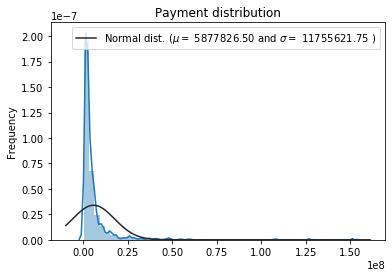

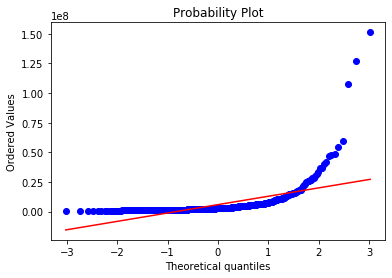

In [779]:
# 是否满足正态分布
sns.distplot(data_to_use['y'] , fit=norm);

(mu, sigma) = norm.fit(data_to_use['y'])
print(f'----mu:{mu:.2f}----sigma:{sigma:.2f}')

#分布图
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Payment distribution')

#QQ图
fig = plt.figure()
res = stats.probplot(data_to_use['y'], plot=plt)
plt.show()

In [793]:
# Prophet(
#     growth='linear',
#     changepoints=None,
#     n_changepoints=25,
#     changepoint_range=0.8,
#     yearly_seasonality='auto',
#     weekly_seasonality='auto',
#     daily_seasonality='auto',
#     holidays=None,
#     seasonality_mode='additive',
#     seasonality_prior_scale=10.0,
#     holidays_prior_scale=10.0,
#     changepoint_prior_scale=0.05,
#     mcmc_samples=0,
#     interval_width=0.8,
#     uncertainty_samples=1000,
#     stan_backend=None,
# )
model = Prophet(changepoint_range=0.092,yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False,holidays=holidays_last
               ,n_changepoints=26,holidays_prior_scale=49,changepoint_prior_scale=0.049,mcmc_samples=49) 
print(len(data_to_use[:366]))
model.fit(data_to_use[:366])

366


In [794]:
future_dates = model.make_future_dataframe(periods=181)
prediction = model.predict(future_dates)
prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-01,14.937089,14.046626,15.841688
1,2020-01-02,14.960359,14.147724,15.850287
2,2020-01-03,15.003560,14.194837,15.837722
3,2020-01-04,15.084750,14.254122,15.935512
4,2020-01-05,15.008146,14.213430,15.864653


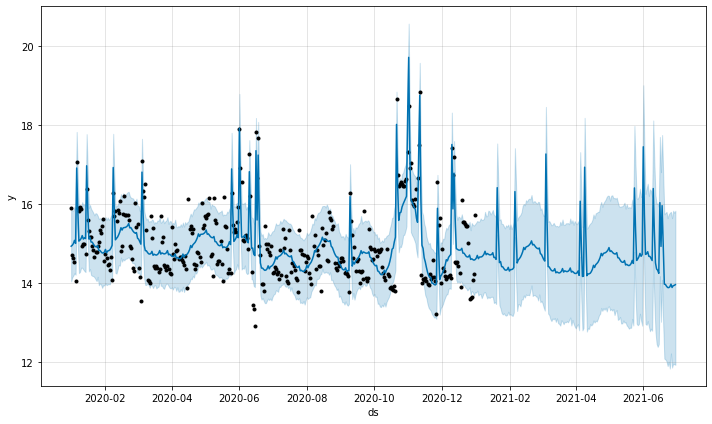

In [795]:
model.plot(prediction)
plt.show()

In [796]:
import numpy as np
def mape(y_true, y_pred):
    """
    参数:
    y_true -- 测试集目标真实值
    y_pred -- 测试集目标预测值
    返回:
    mape -- MAPE 评价指标
    """
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred)/y_true))/n*100
    return mape

print(len(list(prediction['yhat'])))
pridict_ = np.exp(list(prediction['yhat'])[366:])

day_mape = mape(np.array(gmv_day[366:]),np.array(pridict_))
print(f'------测试集日级别上mape：{day_mape}%')

547
------测试集日级别上mape：50.45653368752399%


In [797]:
data_after = pd.DataFrame({'ds':list(prediction['ds'])[366:],'y':gmv_day[366:],'y_pro':pridict_})
data_after['ds']=data_after['ds'].astype(str).tolist()
date=data_after['ds']
data_after['ds'] = date.str.split('-').str[0]+'-'+date.str.split('-').str[1]
data_after

,ds,y,y_pro
0,2021-01,5540628.86,2.257882e+06
1,2021-01,3740098.71,2.431418e+06
2,2021-01,4455760.70,2.238328e+06
3,2021-01,1523788.39,2.334779e+06
4,2021-01,1758128.51,2.335481e+06
...,...,...,...
176,2021-06,996316.48,1.173839e+06
177,2021-06,513678.29,1.078451e+06
178,2021-06,469200.30,1.128423e+06
179,2021-06,440030.21,1.138148e+06


In [798]:
data_month_pro = data_after.groupby('ds')
# 每一月的GMV数据(status=6)
gmv_month_pro= []
for i in tqdm(range(len(list(data_month_pro)))):
    gmv_2=list(data_month_pro)[i][1]['y_pro'].sum()
    gmv_month_pro.append(gmv_2)
gmv_month_pro

[82011464.4854188,
 86354906.90118368,
 88021482.00636737,
 90737952.08715838,
 84194223.19956003,
 122914733.96578208]

In [799]:
data_month = data_after.groupby('ds')
# 每一月的GMV数据(status=6)
gmv_month= []
for i in tqdm(range(len(list(data_month)))):
    gmv_3=list(data_month)[i][1]['y'].sum()
    gmv_month.append(gmv_3)
gmv_month

[155719535.88,
 120081660.46000001,
 165153209.34,
 133661132.42000002,
 167461226.94,
 260668210.02]

In [800]:
month_mape = mape(np.array(gmv_month),np.array(gmv_month_pro))
print(f'------测试集月级别上mape：{month_mape}%')

------测试集日级别上mape：42.80106518471591%


In [802]:
from pyecharts.charts import Line
from pyecharts import options as opts

start_date = "20200101"
date_list = pd.date_range(start=start_date, periods=547).strftime("%Y-%m-%d").tolist()
year_ = date_list[366:]

year_num1 = data_after['y']
print(len(year_num1))
year_num2 = data_after['y_pro']
print(len(year_num2))

print(f'------日级别上rmse：{np.sqrt(np.average((np.array(year_num1) - np.array(year_num2)) ** 2))}')
print(f'------日级别上mape：{mape(np.array(year_num1),np.array(year_num2))}%')


def line_charts() -> Line:
    line = (
        Line()
        .add_xaxis(year_)
        .add_yaxis(
            "真实值",
            year_num1
        )
        .add_yaxis(
            "预测值",
            year_num2
        )
        .set_global_opts(title_opts=opts.TitleOpts(title="prophet模型在测试集上GMV预测图")
                         ,yaxis_opts=opts.AxisOpts(name="GMV")
                         ,xaxis_opts=opts.AxisOpts(name="时间"),)
        .set_series_opts(
            label_opts=opts.LabelOpts(is_show=False),) #
    )
    return line

line = line_charts()
line.render("prophet模型在测试集上预测结果.html")

181
181
------日级别上rmse：5515909.936586017
------日级别上mape：50.45653368752399%


'E:\\py_\\out_work\\YJF_jp_work\\prophet模型在测试集上预测结果.html'